### Importing Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk import edit_distance
from sklearn.feature_extraction.text import CountVectorizer

### Loading the Dataset - Train Batch

In [3]:
data_ACL = pd.read_csv("Data/ACL/train.csv")
data_ACL.head()

,sentence1,sentence2
0,"for all methods , the tweets were tokenized wi...",the tweets were tokenized and part-ofspeech ta...
1,it was shown by nederhof et al that prefix pro...,"nederhof et al , for instance , show that pref..."
2,"first , kikuchi et al proposed a new long shor...","first , kikuchi et al tried to control the len..."
3,with word confusion networks further improves ...,the complexity is dominated by the word confus...
4,fofe can model the word order in a sequence ba...,fofe can model the word order in a sequence us...


In [20]:
set(data_ACL['sentence1'][2].split())

{',',
 '.',
 'a',
 'al',
 'an',
 'by',
 'control',
 'encoder-decoder',
 'et',
 'first',
 'generated',
 'in',
 'kikuchi',
 'length',
 'long',
 'memory',
 'model',
 'network',
 'new',
 'of',
 'proposed',
 'sentence',
 'short-term',
 'summarization',
 'task',
 'text',
 'the',
 'to'}

In [19]:
set(data_ACL['sentence2'][2].split())

{',',
 '.',
 'a',
 'al',
 'an',
 'by',
 'control',
 'encoder-decoder',
 'et',
 'first',
 'generated',
 'in',
 'kikuchi',
 'length',
 'model',
 'of',
 'sentence',
 'summarization',
 'task',
 'text',
 'the',
 'to',
 'tried'}

In [109]:
data_arxiv = pd.read_csv("Data/arXiv/train.csv")
data_arxiv.head()

,sentence1,sentence2
0,we find the optimal alignment of the clean and...,we find the optimal alignment of the original ...
1,end-to-end neural machine translation has gain...,neural machine translation has significantly i...
2,"moreover , asymptotically for large k , the so...","based on the van emde boas tree , the sorting ..."
3,we build on the recent success of deep learnin...,we follow the recent self-localization paradig...
4,the trainable parameters are initialized using...,the weights are initialized using the xavier i...


In [110]:
data_arxiv.shape

(309834, 2)

### Combining the Data Sources

In [111]:
data = pd.concat([data_ACL,data_arxiv],ignore_index=True)
data.head()

,sentence1,sentence2
0,"for all methods , the tweets were tokenized wi...",the tweets were tokenized and part-ofspeech ta...
1,it was shown by nederhof et al that prefix pro...,"nederhof et al , for instance , show that pref..."
2,"first , kikuchi et al proposed a new long shor...","first , kikuchi et al tried to control the len..."
3,with word confusion networks further improves ...,the complexity is dominated by the word confus...
4,fofe can model the word order in a sequence ba...,fofe can model the word order in a sequence us...


In [112]:
data.shape

(338717, 2)

In [113]:
print(data.shape[0] == data_ACL.shape[0] + data_arxiv.shape[0],data.shape)

True (338717, 2)


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338717 entries, 0 to 338716
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentence1  338717 non-null  object
 1   sentence2  338717 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


Column Details:
  1. Column Name: "sentence1"
     - Non-Null Count: 338717
     - Dtype: object
     - Description: This column contains textual data(sci-data).
     - Non-Null Count: Indicates that there are 338,717 non-null (non-missing) entries in this Feature.

  2. Column Name: "sentence2"
     - Non-Null Count: 338717
     - Dtype: object
     - Description: Similar to "sentence1," This column contains textual data(sci-data).
     - Non-Null Count: Indicates that there are 338,717 non-null entries in this Feature.

In [115]:
df = data.copy()

In [11]:
data = data[:1000]

### Let's Perform Some EDA

In [12]:
data['len_sent_1'] = data['sentence1'].apply(len)
data['len_sent_2'] = data['sentence2'].apply(len)

Text(0, 0.5, 'Frequency')

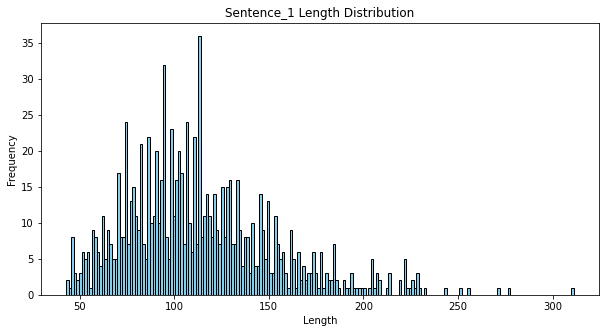

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(data['len_sent_1'], bins=200, color='skyblue', edgecolor='black')
plt.title('Sentence_1 Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

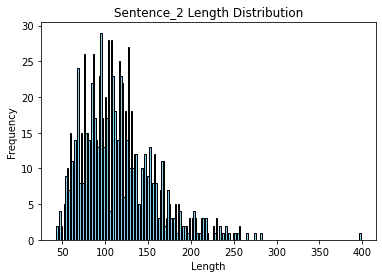

In [14]:
plt.hist(data['len_sent_2'], bins=200, color='skyblue', edgecolor='black')
plt.title('Sentence_2 Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

In [15]:
data['editDistance'] = data.apply(lambda record: edit_distance(record['sentence1'],record['sentence2']),axis=1)

Text(0, 0.5, 'Frequency')

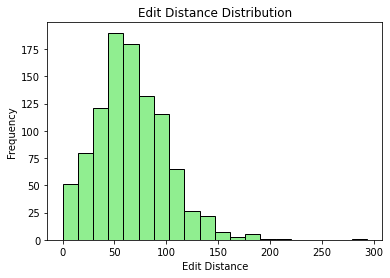

In [16]:
plt.hist(data['editDistance'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Edit Distance Distribution')
plt.xlabel('Edit Distance')
plt.ylabel('Frequency')

In [17]:
data['similarityRation'] = data.apply(lambda record: SequenceMatcher(None,record['sentence1'],record['sentence2']).ratio(),axis=1)

Text(0, 0.5, 'Frequency')

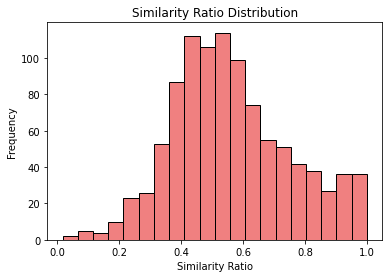

In [18]:
plt.hist(data['similarityRation'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Similarity Ratio Distribution')
plt.xlabel('Similarity Ratio')
plt.ylabel('Frequency')

#### Text-Length Ratio
- This help us understand how much the length changes during paraphrasing.

In [19]:
data['ratioLength'] = data['len_sent_2'] / data['len_sent_1']

Text(0, 0.5, 'Frequency')

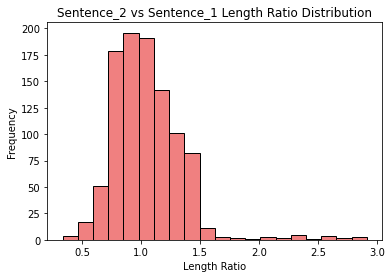

In [20]:
plt.hist(data['ratioLength'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Sentence_2 vs Sentence_1 Length Ratio Distribution')
plt.xlabel('Length Ratio')
plt.ylabel('Frequency')

In [21]:
stop_words = set(stopwords.words('english'))

In [22]:
data['sent_1_stopword_count'] = data['sentence1'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
data['sent_2_stopword_count'] = data['sentence2'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

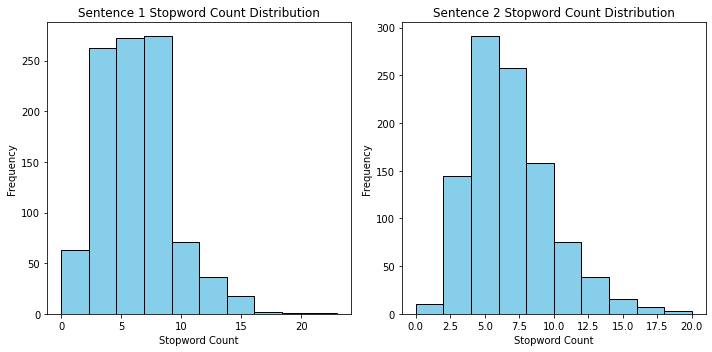

In [23]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(data['sent_1_stopword_count'], bins=10, color='skyblue', edgecolor='black')
plt.title('Sentence 1 Stopword Count Distribution')
plt.xlabel('Stopword Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['sent_2_stopword_count'], bins=10, color='skyblue', edgecolor='black')
plt.title('Sentence 2 Stopword Count Distribution')
plt.xlabel('Stopword Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Word Count Analysis

In [24]:
data['word_count_sent_1'] = data['sentence1'].apply(lambda x: len(x.split()))
data['word_count_sent_2'] = data['sentence2'].apply(lambda x: len(x.split()))

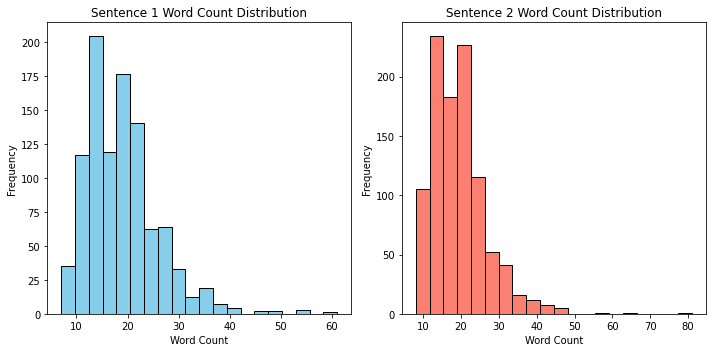

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(data['word_count_sent_1'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentence 1 Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['word_count_sent_2'], bins=20, color='salmon', edgecolor='black')
plt.title('Sentence 2 Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Similar word counts indicate an effort to maintain consistent sentence lengths between Sentence 1 and Sentence 2.

#### Vocabulary Analysis

In [26]:
data['sent_1_vocab_size'] = data['sentence1'].apply(lambda x: len(set(x.split())))
data['sent_2_vocab_size'] = data['sentence2'].apply(lambda x: len(set(x.split())))

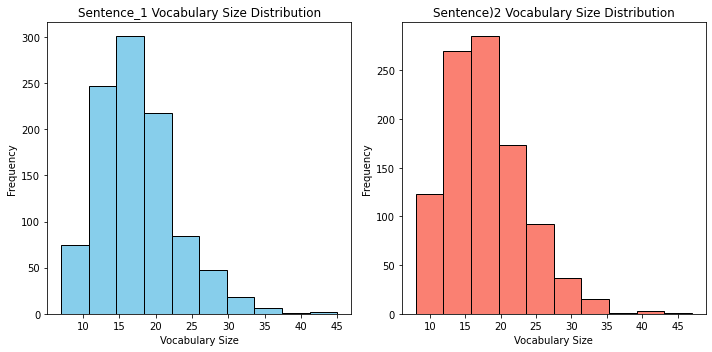

In [27]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(data['sent_1_vocab_size'], bins=10, color='skyblue', edgecolor='black')
plt.title('Sentence_1 Vocabulary Size Distribution')
plt.xlabel('Vocabulary Size')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['sent_2_vocab_size'], bins=10, color='salmon', edgecolor='black')
plt.title('Sentence)2 Vocabulary Size Distribution')
plt.xlabel('Vocabulary Size')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [28]:
data['sent_1_pos_tags'] = data['sentence1'].apply(lambda x: pos_tag(word_tokenize(x)))
data['sent_2_pos_tags'] = data['sentence2'].apply(lambda x: pos_tag(word_tokenize(x)))

In [29]:
print("\nSample POS Tags for Sentence_1:")
print(data['sent_1_pos_tags'].iloc[0])

print("\nSample POS Tags for Sentence_2:")
print(data['sent_2_pos_tags'].iloc[0])


Sample POS Tags for Sentence_1:
[('for', 'IN'), ('all', 'DT'), ('methods', 'NNS'), (',', ','), ('the', 'DT'), ('tweets', 'NNS'), ('were', 'VBD'), ('tokenized', 'VBN'), ('with', 'IN'), ('the', 'DT'), ('cmu', 'NN'), ('twitter', 'NN'), ('nlp', 'JJ'), ('tool', 'NN'), ('.', '.')]

Sample POS Tags for Sentence_2:
[('the', 'DT'), ('tweets', 'NNS'), ('were', 'VBD'), ('tokenized', 'VBN'), ('and', 'CC'), ('part-ofspeech', 'JJ'), ('tagged', 'NN'), ('with', 'IN'), ('the', 'DT'), ('cmu', 'NN'), ('ark', 'NN'), ('twitter', 'NN'), ('nlp', 'JJ'), ('tool', 'NN'), ('and', 'CC'), ('stanford', 'NN'), ('corenlp', 'NN'), ('.', '.')]


In [30]:
def get_top_ngrams(corpus, n=2, top=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top]

## Getting top 10 bigrams for both original and paraphrased sentences
sent_1_bigrams = get_top_ngrams(data['sentence1'], n=2)
sent_2_bigrams = get_top_ngrams(data['sentence2'], n=2)

print("\nTop 10 Sentence_1 Bigrams:")
print(sent_1_bigrams)

print("\nTop 10 Sentence_2 Bigrams:")
print(sent_2_bigrams)


Top 10 Sentence_1 Bigrams:
[('et al', 94), ('of the', 93), ('language model', 82), ('we use', 82), ('using the', 79), ('on the', 72), ('is the', 66), ('in the', 62), ('we used', 62), ('in this', 60)]

Top 10 Sentence_2 Bigrams:
[('we use', 92), ('et al', 91), ('of the', 90), ('language model', 75), ('using the', 74), ('is the', 67), ('in the', 64), ('we used', 58), ('on the', 56), ('in this', 56)]


In [31]:
def visualize_top_ngrams(ngrams, title):
    words, frequencies = zip(*ngrams)
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.show()

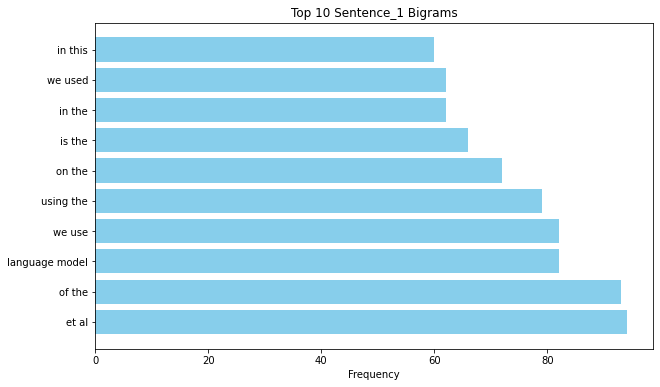

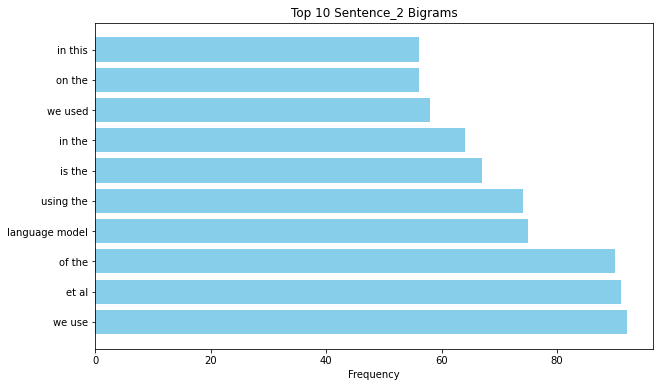

In [32]:
visualize_top_ngrams(sent_1_bigrams,'Top 10 Sentence_1 Bigrams')
visualize_top_ngrams(sent_2_bigrams, 'Top 10 Sentence_2 Bigrams')